<a href="https://www.kaggle.com/code/mohamedhassan1911/hand-gestures?scriptVersionId=113448264" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Hand Gesture Recognition

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#CNN">CNN modle</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

> This dataset collects 

> Description of all features and the data itself is [here]()

In [3]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.layers.experimental.preprocessing as AugLayers
from tensorflow.keras import regularizers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [4]:
df_train = pd.read_csv("/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv")
df_test = pd.read_csv('/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv')
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [5]:
# import os
# current_directory = os.getcwd()

# df_train = pd.read_csv(current_directory + '\DataSource' + '\sign_mnist_train.csv')
# df_test = pd.read_csv(current_directory + '\DataSource' + '\sign_mnist_test.csv')
# df_train.head(2)

> taking 20% of train dataset for validation

In [6]:
# First shuffling the train dataset
df_train = df_train.sample(frac = 1).reset_index(drop=True)

validation_untill = int(0.2 * df_train.shape[0])
df_validation     = df_train.iloc[:validation_untill, :]
df_train          = df_train.iloc[validation_untill:, :]

print(f'Shape of validation is   : {df_validation.shape}\nShape of train dataset is: {df_train.shape}')

Shape of validation is   : (5491, 785)
Shape of train dataset is: (21964, 785)


In [7]:
print(f'Shape of Train dataSet is: {df_train.shape}')
print(f'Shape of test  dataSet is: {df_test.shape}')

Shape of Train dataSet is: (21964, 785)
Shape of test  dataSet is: (7172, 785)


In [8]:
# Resetting indecies to 0, 1, 2 ...
df_train = df_train.reset_index(drop=True)
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,11,150,154,155,158,163,167,170,172,175,...,126,123,123,123,121,121,120,121,119,118
1,23,198,201,205,208,209,211,212,211,212,...,72,66,56,50,57,58,61,49,48,56
2,6,166,167,171,172,173,174,173,173,173,...,211,212,211,210,211,211,211,208,209,207
3,21,56,75,82,89,94,97,99,102,105,...,105,67,22,107,167,156,158,157,157,157
4,14,192,191,191,193,193,192,192,194,193,...,164,185,199,196,192,196,196,203,199,197


<a id='eda'></a>
## Exploratory Data Analysis

> Making reialable labels, Comes form the original dataSet

In [9]:
import string
Alphabet_labels = list(string.ascii_letters)

> Converting images into shape of w x h

In [10]:
# Frist for train images
imgWidth = int(np.sqrt(len(df_train.columns) - 1))


X_train = df_train.loc[:, 'pixel1':] / 255
print(f'Shape befor resizing: {X_train.shape}')
X_train = X_train.values.reshape(-1, imgWidth, imgWidth)
print(f'Shape after resizing: {X_train.shape}')

Shape befor resizing: (21964, 784)
Shape after resizing: (21964, 28, 28)


In [11]:
Y_train = df_train.loc[:, 'label']

In [12]:
# Second for validation images
imgWidth = int(np.sqrt(len(df_validation.columns) - 1))

X_val = df_validation.loc[:, 'pixel1':] / 255
print(f'Shape befor resizing: {X_val.shape}')
X_val = X_val.values.reshape(-1, imgWidth, imgWidth)
print(f'Shape after resizing: {X_val.shape}')

Shape befor resizing: (5491, 784)
Shape after resizing: (5491, 28, 28)


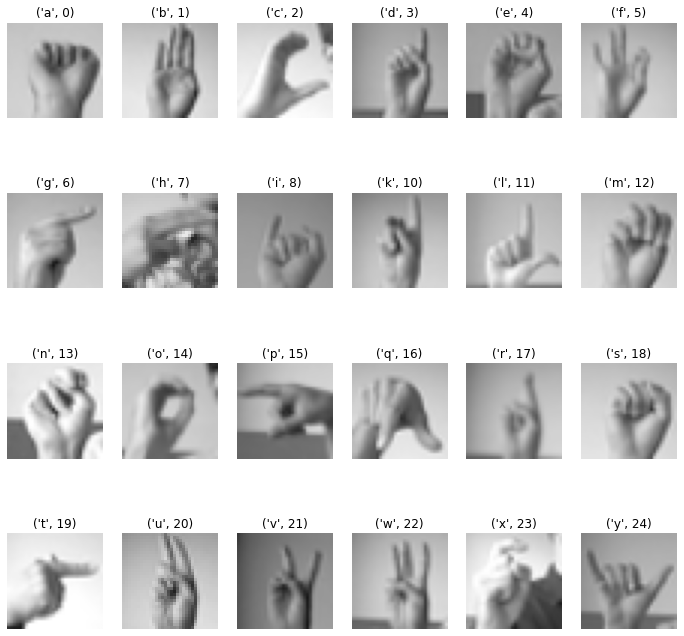

In [70]:
figure = plt.figure(figsize=(12, 12))
for i in range(24):
    ax = plt.subplot(4, 6, i + 1)
    plt.imshow(img[i])
    plt.title((Alphabet_labels[np.unique(Y_train)[i]], np.unique(Y_train)[i]))
    plt.axis('off')

In [15]:
df_train = df_validation = []
del df_train
del df_validation

> Resizing images to be 32 x 32 x 3 as the minimum values for MobileNet2

In [16]:
temp_train = []
temp_val   = []
print(f'Shape befor resizing: {X_train[0].shape}')

for i in range(len(X_train)):
    gray_resized_img = cv2.resize(X_train[i], (32, 32))                                       # Resizing it to be 32 x 32.
    img_with_3Channels = cv2.merge((gray_resized_img, gray_resized_img, gray_resized_img))    # Converting it to RGB image.
    temp_train.append(img_with_3Channels)
    
for i in range(len(X_val)):
    gray_resized_img = cv2.resize(X_val[i], (32, 32))                                         # Resizing it to be 32 x 32.
    img_with_3Channels = cv2.merge((gray_resized_img, gray_resized_img, gray_resized_img))    # Converting it to RGB image.
    temp_val.append(img_with_3Channels)
    
    
X_train = np.array(temp_train)
X_val   = np.array(temp_val)

print(f'New shape is: {X_train[0].shape}')

Shape befor resizing: (28, 28)
New shape is: (32, 32, 3)


> After running the model, found that there is an Overfitting. As out data is small. So, let't increase them.

### Data Augmentation

In [17]:
datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

Augmented_Images = []
Labels_of_augmented_iamges = []

for i in range(len(X_train)):
    augmented = datagen.flow(np.expand_dims(X_train[i], 0))
    for j in range(3): # Making 3 augmented images for each image in training dataset.
        img = next(iter(augmented))
        Augmented_Images.append(img)
        Labels_of_augmented_iamges.append(Y_train[i])

print(f'X_train befor augmantation has the shape of: {X_train.shape}')
X_train = np.concatenate((X_train, np.array(Augmented_Images).squeeze()))
Y_train = np.concatenate((Y_train, np.array(Labels_of_augmented_iamges)))
print(f'New shape is: {X_train.shape}')

X_train befor augmantation has the shape of: (21964, 32, 32, 3)
New shape is: (87856, 32, 32, 3)


In [18]:
Augmented_Images = []
Labels_of_augmented_iamges = []

for i in range(len(X_val)):
    augmented = datagen.flow(np.expand_dims(X_val[i], 0))
    for j in range(3): # Making 3 augmented images for each image in training dataset.
        img = next(iter(augmented))
        Augmented_Images.append(img)
        Labels_of_augmented_iamges.append(Y_val[i])

print(f'X_val befor augmantation has the shape of: {X_val.shape}')
X_val = np.concatenate((X_val, np.array(Augmented_Images).squeeze()))
Y_val= np.concatenate((Y_val, np.array(Labels_of_augmented_iamges)))
print(f'New shape is: {X_val.shape}')

X_val befor augmantation has the shape of: (5491, 32, 32, 3)
New shape is: (21964, 32, 32, 3)


> Now lets plot some augmented images

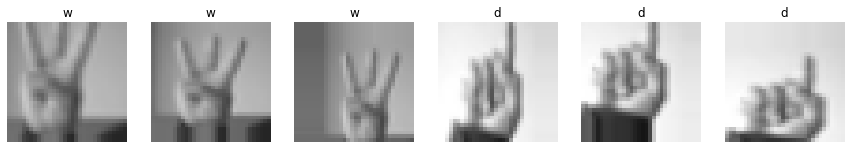

In [19]:
figure = plt.figure(figsize=(15, 15))
for i in range(6):
    ax = plt.subplot(1, 6, i + 1)
    plt.imshow(Augmented_Images[i+15][0,:,:,:])
    plt.title(Alphabet_labels[Labels_of_augmented_iamges[i+15]])
    plt.axis('off')

<a id='CNN'></a>
## CNN Model

In [20]:
process_input =  tf.keras.applications.mobilenet_v2.preprocess_input

> Making Callbacks, first with the checkpoints for best validation_set model.

In [21]:
checkpoint_path = "checkpoints/"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 save_best_only=True,
                                                 mode='max',
                                                 verbose=1)

> Learning Rate decay

In [22]:
def scheduler(epoch, lr):
    if epoch < 2:
        return lr
    else:
        return lr * 0.99

    
lr_Scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

> Early stopping, to stop training if validation accuracy didn't improve for 3 epoches

In [23]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [49]:
def model(input_size = (32, 32)):
    imgSize = input_size + (3, )
    
    base_model = tf.keras.applications.MobileNetV2(
        input_shape = imgSize,
        include_top = False,
        weights     = 'imagenet')
    
    base_model.trainable = False
    
    
    inputs = tfl.Input(shape = imgSize)
    x      = process_input(inputs)
    
    x      = base_model(inputs, training = False)
    x      = tfl.GlobalAveragePooling2D()(x)
    
    x      = tfl.Dense(125, activation = 'relu')(x)
#     x      = tfl.Dropout(0.2)(x) 
    
    Outputs      = tfl.Dense(26, activation="softmax")(x)
    
    modle = tf.keras.Model(inputs, Outputs)

    return modle

In [50]:
Model = model()

In [51]:
# Unfreezing some layers
base_model = Model.layers[1]
base_model.trainable = True

freezing = len(base_model.layers) - 3
for layer in base_model.layers[:freezing]:
    layer.trainable = False

In [52]:
Model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 1, 1, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 125)               160125    
_________________________________________________________________
dense_7 (Dense)              (None, 26)                3276      
Total params: 2,421,385
Trainable params: 575,561
Non-trainable params: 1,845,824
_________________________________________________________________


In [53]:
Model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             metrics=['accuracy'])

In [54]:
history = Model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10, batch_size = 128, verbose=1, callbacks=[cp_callback, early_stop])

Epoch 1/10
687/687 [==============================] - 15s 17ms/step - loss: 1.1444 - accuracy: 0.6240 - val_loss: 0.7502 - val_accuracy: 0.7459

Epoch 00001: val_accuracy did not improve from 0.87443
Epoch 2/10
687/687 [==============================] - 10s 15ms/step - loss: 0.6762 - accuracy: 0.7711 - val_loss: 0.6808 - val_accuracy: 0.7698

Epoch 00002: val_accuracy did not improve from 0.87443
Epoch 3/10
687/687 [==============================] - 11s 16ms/step - loss: 0.5658 - accuracy: 0.8080 - val_loss: 0.5893 - val_accuracy: 0.8026

Epoch 00003: val_accuracy did not improve from 0.87443
Epoch 4/10
687/687 [==============================] - 11s 16ms/step - loss: 0.5002 - accuracy: 0.8307 - val_loss: 0.4979 - val_accuracy: 0.8342

Epoch 00004: val_accuracy did not improve from 0.87443
Epoch 5/10
687/687 [==============================] - 10s 15ms/step - loss: 0.4566 - accuracy: 0.8449 - val_loss: 0.4720 - val_accuracy: 0.8418

Epoch 00005: val_accuracy did not improve from 0.87443


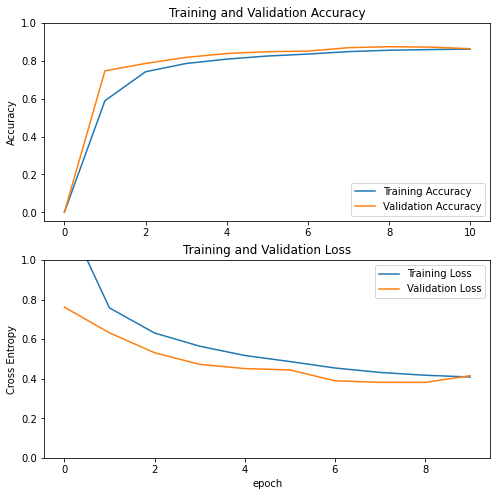

In [30]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [55]:
np.unique(Y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

In [31]:
# del df_train
# del df_validation
# del X_train
# del Y_train
# del X_val
# del Y_val

In [32]:
Model.save('SwhiMee2.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [33]:
results = Model.predict(X_train)

2022-12-10 11:51:24.390367: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1079574528 exceeds 10% of free system memory.
2022-12-10 11:51:25.592227: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1079574528 exceeds 10% of free system memory.


In [34]:
i = 2
print(f'Predicted_value: {Alphabet_labels[np.argmax(results[i])]}\nThe actual value: {Alphabet_labels[Y_tarin[i]]}')

NameError: name 'Y_tarin' is not defined

<a id='conclusions'></a>
## Conclusions